**Goal and preface:** This notebook is an attempt to learn how GNN can help upscaling materials discovery faster based on the paper *'https://doi.org/10.1038/s41586-023-06735-9'* by Amil Merchant et.al.  
The key methodologies of the paper are as follows:  
Diversified generation (SAPS, relaxed-OS formulas + AIRSS) → scale-tuned GNN energy models (ensembles + TTAs) → DFT verification →   
active-learning retraining, all under reproducible dataset snapshots and careful leakage control. The resulting dataset also pretrains equivariant MLIPs that generalize zero-shot to downstream property simulations. 

Step 0: Setting API to parse a mini dataset from 'Materials Project' database.  

In [ ]:
# import os
# from getpass import getpass

# api_key = os.getenv("MP_API_KEY")

# if "MP_API_KEY" not in os.environ:
#     os.environ["MP_API_KEY"] = getpass("Enter your MP_API_KEY (hidden input): ")


# Data parsing
**Miniature semiconductor systems**   

**Steps (via MP-api)**  

*Setting API → select FIELDS (incl. structure, use nelements field) → define chemistry menus (III–V, II–VI, group-IV binaries; III–V–N, III–V–VI ternaries)*  
*→ build pairs/ternaries (dedup, guarantee ternaries are triples) → fetch helper (materials.summary.search(elements=..., num_elements=..., chunk_size, num_chunks=1); suppress progress)*  
*→ collect (loop binaries → then ternaries until TARGET_N; keep only 0 < Eg < 4eV; track seen by material_id) → serialize (JSON.gz full: structure.as_dict(), Element→symbol; CSV.gz comp-only)*

In [ ]:
# # setting env var outside Python to silence tqdm globally (preferred)
# # Windows (CMD):   set DISABLE_TQDM=1
# # PowerShell:      $env:DISABLE_TQDM="1"
# # macOS/Linux:     export DISABLE_TQDM=1

# import os, sys, gzip, json, itertools, contextlib
# import pandas as pd
# from mp_api.client import MPRester

# # ----------------------------
# # config
# # ----------------------------

# INCLUDE_STRUCTURE = True
# TARGET_N = 10_000
# EG_MIN, EG_MAX = 0.0, 4.0     # setting semiconductor-ish window

# # setting fields (include 'structure' for structure-based pipeline)
# # note: 'nelements' is a FIELD on docs; 'num_elements' is the FILTER param
# FIELDS = [
#     "material_id", "formula_pretty", "elements", "nelements",
#     "formation_energy_per_atom", "energy_above_hull", "is_stable",
#     "band_gap", "is_metal", "density"
# ]
# if INCLUDE_STRUCTURE:
#     FIELDS.append("structure")

# # setting element families commonly seen in semiconductors
# group_IV = ["C","Si","Ge","Sn"]
# III      = ["B","Al","Ga","In"]
# V        = ["N","P","As","Sb","Bi"]
# II       = ["Zn","Cd","Hg","Mg","Be","Ca","Sr","Ba"]
# VI       = ["O","S","Se","Te"]
# halides  = ["F","Cl","Br","I"]  # available if you want I–VII

# # ----------------------------
# # utilities
# # ----------------------------

# # setting a context manager to suppress tqdm/progress output from mp_api calls
# @contextlib.contextmanager
# def suppress_progress():
#     with open(os.devnull, "w") as devnull:
#         old_out, old_err = sys.stdout, sys.stderr
#         try:
#             sys.stdout, sys.stderr = devnull, devnull
#             yield
#         finally:
#             sys.stdout, sys.stderr = old_out, old_err

# # setting builders for pairs and ternaries
# def build_pairs():
#     pairs = []
#     pairs += list(itertools.product(III, V))            # III–V
#     pairs += list(itertools.product(II, VI))            # II–VI
#     pairs += list(itertools.combinations(group_IV, 2))  # group-IV binaries
    
#     pairs += list(itertools.product(group_IV, VI))     # IV–VI (e.g., SnSe, GeS)
#     pairs += list(itertools.product(["Cu","Ag"], VI))  # I–VI (for chalco precursors)
#     seen, ordered = set(), []
#     for p in pairs:
#         key = tuple(sorted(p))
#         if key not in seen:
#             seen.add(key)
#             ordered.append(tuple(p))
#     return ordered

# def build_ternaries():
#     s = set()
#     # III–V–N
#     for a, b in itertools.product(III, V):
#         s.add(tuple(sorted((a, b, "N"))))
#     # III–V–VI
#     for a, b, c in itertools.product(III, V, VI):
#         s.add(tuple(sorted((a, b, c))))
    
#     for a, b, c in itertools.product(["Cu","Ag"], III, VI):  # I–III–VI2 chalcopyrites
#         s.add(tuple(sorted((a, b, c))))
#     for a, b, c in itertools.product(II, group_IV, V):       # II–IV–V2 (e.g., ZnSiAs2)
#         s.add(tuple(sorted((a, b, c))))
#     out = [t for t in s if isinstance(t, (tuple, list)) and len(t) == 3]
#     return sorted(out)

# pairs = build_pairs()
# ternaries = build_ternaries()

# # setting fetch helper using 'num_elements' filter; suppressing progress per call
# def fetch_elements_combo(required_elements, num_elements=2, chunk_size=400, max_chunks=100):
#     out = []
#     with MPRester(os.environ["MP_API_KEY"]) as mpr:
#         for _ in range(max_chunks):
#             with suppress_progress():
#                 docs = mpr.materials.summary.search(
#                     elements=list(required_elements),
#                     num_elements=num_elements,
#                     fields=FIELDS,
#                     num_chunks=1,
#                     chunk_size=chunk_size
#                 )
#             if not docs:
#                 break
#             out.extend(docs)
#             if len(docs) < chunk_size:
#                 break
#     return out

# # ----------------------------
# # collection + band gap filter
# # ----------------------------

# seen = set()
# collected = []

# def add_docs(docs):
#     added = 0
#     for d in docs:
#         mid = getattr(d, "material_id", None)
#         if not mid or mid in seen:
#             continue
#         Eg = getattr(d, "band_gap", None)
#         if Eg is None or not (EG_MIN < Eg < EG_MAX):
#             continue
#         collected.append(d)
#         seen.add(mid)
#         added += 1
#     return added

# # ----------------------------
# # run: binaries first, then ternaries
# # ----------------------------

# for a, b in pairs:
#     add_docs(fetch_elements_combo([a, b], num_elements=2, chunk_size=400, max_chunks=30))
#     if len(collected) >= TARGET_N:
#         break

# if len(collected) < TARGET_N:
#     for a, b, c in ternaries:
#         add_docs(fetch_elements_combo([a, b, c], num_elements=3, chunk_size=400, max_chunks=25))
#         if len(collected) >= TARGET_N:
#             break

# print(f"Collected {len(collected)} unique semiconductor-like entries (binaries/ternaries).")

# # ----------------------------
# # serialization helpers (JSON-safe)
# # ----------------------------

# def to_symbol_list(elems):
#     # converting Element objects -> symbols; leaving strings untouched
#     try:
#         if elems and not isinstance(elems[0], str):
#             return [getattr(e, "symbol", str(e)) for e in elems]
#     except Exception:
#         pass
#     return elems

# def structure_to_dict(s):
#     # converting Structure to plain dict; handling dict/None gracefully
#     if s is None:
#         return None
#     if isinstance(s, dict):
#         return s
#     # try as_dict(), else try to_json() -> dict
#     try:
#         return s.as_dict()
#     except Exception:
#         try:
#             return json.loads(s.to_json())
#         except Exception:
#             return str(s)  # last resort: stringify

# class MPJSONEncoder(json.JSONEncoder):
#     # handling pymatgen Element, numpy types, and MSONable objects
#     def default(self, o):
#         try:
#             from pymatgen.core.periodic_table import Element
#             if isinstance(o, Element):
#                 return o.symbol
#         except Exception:
#             pass
#         try:
#             import numpy as np
#             if isinstance(o, (np.integer,)):
#                 return int(o)
#             if isinstance(o, (np.floating,)):
#                 return float(o)
#             if isinstance(o, (np.ndarray,)):
#                 return o.tolist()
#         except Exception:
#             pass
#         if hasattr(o, "as_dict"):
#             return o.as_dict()
#         return super().default(o)

# # ----------------------------
# # material dicts
# # ----------------------------

# def doc_to_plain(d):
#     base = {
#         "material_id": d.material_id,
#         "formula_pretty": d.formula_pretty,
#         "elements": to_symbol_list(d.elements),
#         "nelements": d.nelements,
#         "formation_energy_per_atom": d.formation_energy_per_atom,
#         "energy_above_hull": d.energy_above_hull,
#         "is_stable": d.is_stable,
#         "band_gap": d.band_gap,
#         "is_metal": d.is_metal,
#         "density": d.density,
#     }
#     if INCLUDE_STRUCTURE and getattr(d, "structure", None) is not None:
#         base["structure"] = structure_to_dict(d.structure)
#     return base

# plain = [doc_to_plain(d) for d in collected]

# # ----------------------------
# # write: JSON (full) + CSV (composition-only)
# # ----------------------------

# os.makedirs("data", exist_ok=True)
# suffix = "with_struct" if INCLUDE_STRUCTURE else "comp_only"

# # writing full json.gz (safe encoder)
# json_path = f"data/semiconductors_full_{suffix}.json.gz"
# with gzip.open(json_path, "wt") as f:
#     json.dump(plain, f, cls=MPJSONEncoder)
# print(f"✅ saved JSON → {json_path} (records: {len(plain)})")

# # writing CSV.gz (composition-only; omitting 'structure')
# csv_cols = ["material_id","formula_pretty","elements","nelements",
#             "formation_energy_per_atom","energy_above_hull","is_stable",
#             "band_gap","is_metal","density"]
# df = pd.DataFrame([{k: rec.get(k) for k in csv_cols} for rec in plain])
# csv_path = f"data/semiconductors_comp_only.csv.gz"
# df.to_csv(csv_path, index=False, compression="gzip")
# print(f"✅ saved CSV  → {csv_path} (rows: {len(df)})")

# # quick peek
# print(df.shape)
# print(df.head(3))

Collected 1285 unique semiconductor-like entries (binaries/ternaries).
✅ saved JSON → data/semiconductors_full_with_struct.json.gz (records: 1285)
✅ saved CSV  → data/semiconductors_comp_only.csv.gz (rows: 1285)
(1285, 10)
  material_id formula_pretty elements  nelements  formation_energy_per_atom  \
0  mp-1244872             BN   [B, N]          2                  -0.771438   
1  mp-1244917             BN   [B, N]          2                  -0.496787   
2  mp-1244943             BN   [B, N]          2                  -0.756250   

   energy_above_hull  is_stable  band_gap  is_metal   density  
0           0.641541      False    1.5766     False  1.574835  
1           0.916192      False    1.1992     False  1.588014  
2           0.656729      False    1.1885     False  1.708090  


In [1]:
import torch

# Dataset preparation

**a. Composition pipeline**    

load raw comp dataset → standardize columns/types → filter valid rows → attach Composition objects → featurize elemental stats → assemble X,y → persist features → quick QA

*a.1: (load + standardize + initial filtering)*  

In [2]:
# setting paths
RAW_CSV = "data/semiconductors_comp_only.csv.gz"
CLEAN_CSV = "data/comp_raw_clean.csv.gz"

# importing libs
import ast
import pandas as pd

# reading comp-only dataset  
df = pd.read_csv(RAW_CSV)

# standardizing columns expected downstream
required_cols = ["material_id","formula_pretty","elements","nelements","band_gap"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"missing columns in raw file: {missing}")

# converting 'elements' column from string repr -> python list[str]
def _parse_elems(x):
    # handling NaN or already-a-list
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return None
    try:
        obj = ast.literal_eval(x)
        if isinstance(obj, list):
            # enforcing strings (symbols) only
            return [str(e) for e in obj]
    except Exception:
        pass
    # fallback: split on non-letters if a weird string sneaks in
    return [tok for tok in str(x).replace("[","").replace("]","").replace("'","").split(",") if tok.strip()]

df["elements"] = df["elements"].apply(_parse_elems)

# dropping bad rows (no elements list, no formula, invalid Eg)
df = df.dropna(subset=["formula_pretty","elements","band_gap"])
df = df[df["band_gap"].between(0, 4, inclusive="neither")]

# dropping duplicate materials (keeping the first)
if "material_id" in df.columns:
    df = df.drop_duplicates(subset=["material_id"])

# saving cleaned raw for the next substep
df.to_csv(CLEAN_CSV, index=False, compression="gzip")

# counting binaries/ternaries
n_bin  = int((df["nelements"] == 2).sum())
n_ter  = int((df["nelements"] == 3).sum())


# quick peek
print(f"✅ cleaned comp dataset → {CLEAN_CSV} | rows={len(df)}")
print(df[["material_id","formula_pretty","elements","nelements","band_gap"]].head(5))
print(f"binaries: {n_bin} | ternaries: {n_ter} ")

✅ cleaned comp dataset → data/comp_raw_clean.csv.gz | rows=1285
  material_id formula_pretty elements  nelements  band_gap
0  mp-1244872             BN   [B, N]          2    1.5766
1  mp-1244917             BN   [B, N]          2    1.1992
2  mp-1244943             BN   [B, N]          2    1.1885
3  mp-1244991             BN   [B, N]          2    1.5503
4  mp-1245193             BN   [B, N]          2    0.2781
binaries: 619 | ternaries: 666 


*a.2: composition prep*  

load raw comp dataset → attach Composition objects

In [3]:
# setting paths
CLEAN_CSV = "data/comp_raw_clean.csv.gz"
COMP_CACHE_CSV = "data/comp_cache.csv.gz"

# importing libs
import json
import pandas as pd
from pymatgen.core.composition import Composition

# loading cleaned dataset
df = pd.read_csv(CLEAN_CSV)

# setting safe Composition parser
def to_comp_safe(formula: str):
    try:
        return Composition(str(formula))
    except Exception:
        return None

df["comp_obj"] = df["formula_pretty"].apply(to_comp_safe)
df["comp_ok"] = df["comp_obj"].notna()

# dropping rows that failed to parse
n_fail = int((~df["comp_ok"]).sum())
if n_fail:
    print(f"dropping {n_fail} rows that failed Composition() parsing")
df = df[df["comp_ok"]].copy()

# setting element→amount maps (keys are symbols, values are floats)
def el_amt_map(c: Composition):
    d = c.get_el_amt_dict()  # keys already symbols in current pymatgen
    return {str(k): float(v) for k, v in d.items()}

df["comp_el_amt"]   = df["comp_obj"].apply(el_amt_map)
df["comp_mson"]     = df["comp_obj"].apply(lambda c: c.as_dict())

# serializing dicts for CSV
df["comp_el_amt_json"] = df["comp_el_amt"].apply(json.dumps)
df["comp_mson_json"]   = df["comp_mson"].apply(json.dumps)

# saving compact cache for next substep
cache_cols = [
    "material_id","formula_pretty","elements","nelements","band_gap",
    "comp_el_amt_json","comp_mson_json"
]
df[cache_cols].to_csv(COMP_CACHE_CSV, index=False, compression="gzip")

# quick QA
print(f"✅ comp cache saved → {COMP_CACHE_CSV} | rows={len(df)}")
print(df[["material_id","formula_pretty","nelements","band_gap","comp_el_amt"]].head(3))

✅ comp cache saved → data/comp_cache.csv.gz | rows=1285
  material_id formula_pretty  nelements  band_gap           comp_el_amt
0  mp-1244872             BN          2    1.5766  {'B': 1.0, 'N': 1.0}
1  mp-1244917             BN          2    1.1992  {'B': 1.0, 'N': 1.0}
2  mp-1244943             BN          2    1.1885  {'B': 1.0, 'N': 1.0}


*a.3: : featurize elemental stats*

In [4]:
import math
# setting paths
COMP_CACHE_CSV = "data/comp_cache.csv.gz"

from pymatgen.core import Element
import numpy as np

# loading composition cache
df = pd.read_csv(COMP_CACHE_CSV)

# parsing element→amount dicts (unnormalized), then making fractions
def parse_el_amt(s):
    try:
        d = json.loads(s)
        # forcing keys as symbols, values as float
        d = {str(k): float(v) for k, v in d.items()}
        total = sum(d.values())
        if total <= 0:
            return None, None
        fracs = {k: v / total for k, v in d.items()}
        return d, fracs
    except Exception:
        return None, None

el_amt_fracs = df["comp_el_amt_json"].apply(parse_el_amt)
df["el_amt"]   = [t[0] for t in el_amt_fracs]
df["el_fracs"] = [t[1] for t in el_amt_fracs]
df = df.dropna(subset=["el_fracs"]).reset_index(drop=True)

# setting elemental properties to aggregate
# using: atomic number (Z), Pauling electronegativity (X), atomic mass, Mendeleev number, atomic radius
PROP_FUNCS = {
    "Z":               lambda e: e.Z,
    "X":               lambda e: e.X,                 # may be None for some elements
    "mass":            lambda e: float(e.atomic_mass) if e.atomic_mass is not None else np.nan,
    "mendeleev_no":    lambda e: e.mendeleev_no,
    "atomic_radius":   lambda e: e.atomic_radius,     # may be None
}

# setting helper to get numeric array for a property given fraction dict
def prop_values_and_weights(fracs: dict, prop_key: str):
    vals, wts = [], []
    fn = PROP_FUNCS[prop_key]
    for sym, w in fracs.items():
        try:
            e = Element(sym)
            v = fn(e)
        except Exception:
            v = np.nan
        vals.append(np.nan if v is None else float(v))
        wts.append(float(w))
    return np.array(vals, dtype=float), np.array(wts, dtype=float)

# setting weighted stats (fractions already sum to 1)
def weighted_stats(vals: np.ndarray, wts: np.ndarray):
    # drop NaNs in vals (adjust weights)
    mask = ~np.isnan(vals)
    if not np.any(mask):
        return dict(mean=np.nan, std=np.nan, vmin=np.nan, vmax=np.nan, vrange=np.nan)
    v = vals[mask]
    w = wts[mask]
    w = w / w.sum()
    m = np.sum(w * v)
    var = np.sum(w * (v - m) ** 2)
    s = math.sqrt(var)
    vmin, vmax = float(np.min(v)), float(np.max(v))
    return dict(mean=float(m), std=float(s), vmin=vmin, vmax=vmax, vrange=float(vmax - vmin))

# setting composition diversity metrics
def comp_entropy(fracs: dict):
    p = np.array(list(fracs.values()), dtype=float)
    return float(-np.sum(p * np.log(p)))  # natural log

def comp_max_fraction(fracs: dict):
    return float(max(fracs.values()))

# computing features
feat_rows = []
for i, row in df.iterrows():
    fr = row["el_fracs"]
    feats = {
        "material_id": row["material_id"],
        "nelements": row["nelements"],
        "H_composition": comp_entropy(fr),
        "max_elem_frac": comp_max_fraction(fr),
    }
    for pk in PROP_FUNCS.keys():
        vals, wts = prop_values_and_weights(fr, pk)
        st = weighted_stats(vals, wts)
        feats[f"{pk}_mean"]   = st["mean"]
        feats[f"{pk}_std"]    = st["std"]
        feats[f"{pk}_min"]    = st["vmin"]
        feats[f"{pk}_max"]    = st["vmax"]
        feats[f"{pk}_range"]  = st["vrange"]
    feat_rows.append(feats)

comp_feats = pd.DataFrame(feat_rows)

# joining back light metadata for convenience
comp_feats = comp_feats.merge(df[["material_id","formula_pretty","band_gap"]], on="material_id", how="left")

# quick QA
print(f"✅ composition features computed | rows={len(comp_feats)} | cols={comp_feats.shape[1]}")
print(comp_feats.head(3)[[
    "material_id","nelements","H_composition","max_elem_frac",
    "Z_mean","Z_std","X_mean","X_std","mass_mean","mass_std","band_gap"
]])

✅ composition features computed | rows=1285 | cols=31
  material_id  nelements  H_composition  max_elem_frac  Z_mean  Z_std  X_mean  \
0  mp-1244872          2       0.693147            0.5     6.0    1.0    2.54   
1  mp-1244917          2       0.693147            0.5     6.0    1.0    2.54   
2  mp-1244943          2       0.693147            0.5     6.0    1.0    2.54   

   X_std  mass_mean  mass_std  band_gap  
0    0.5   12.40885   1.59785    1.5766  
1    0.5   12.40885   1.59785    1.1992  
2    0.5   12.40885   1.59785    1.1885  


*a.4: assemble X, y*

In [5]:
# setting paths
FEATS_ALL_PATH   = "data/comp_X_all.parquet"
TARGET_ALL_PATH  = "data/comp_y_all.parquet"
XTR_PATH, XVA_PATH = "data/comp_X_train.parquet", "data/comp_X_valid.parquet"
YTR_PATH, YVA_PATH = "data/comp_y_train.parquet", "data/comp_y_valid.parquet"

# importing libs
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# expecting 'comp_feats' from previous substep; failing fast if missing
if "comp_feats" not in globals():
    raise RuntimeError("comp_feats not found. Run the previous substep to build composition features.")

# selecting feature columns (numerics only, drop metadata/target)
meta_cols = {"material_id","formula_pretty","band_gap"}
num_df = comp_feats.drop(columns=[c for c in meta_cols if c in comp_feats.columns])
num_df = num_df.select_dtypes(include=[np.number])

# dropping columns with too many NaNs (setting threshold = 30%)
na_ratio = num_df.isna().mean()
drop_cols = list(na_ratio[na_ratio > 0.30].index)
if drop_cols:
    print(f"dropping {len(drop_cols)} cols with >30% NaNs")
    num_df = num_df.drop(columns=drop_cols)

# replacing infs -> NaN then imputing with column medianss
num_df = num_df.replace([np.inf, -np.inf], np.nan)
medians = num_df.median(axis=0, numeric_only=True)
num_df = num_df.fillna(medians)

# enforcing float32 for compactness/speed
X = num_df.astype(np.float32)
y = comp_feats["band_gap"].astype(np.float32)

# saving full matrices (for later reuse)
X.to_parquet(FEATS_ALL_PATH, index=False)
y.to_frame("band_gap").to_parquet(TARGET_ALL_PATH, index=False)

# creating a simple train/valid split (setting random_state for reproducibility)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)

# saving split
X_tr.to_parquet(XTR_PATH, index=False)
X_va.to_parquet(XVA_PATH, index=False)
y_tr.to_frame("band_gap").to_parquet(YTR_PATH, index=False)
y_va.to_frame("band_gap").to_parquet(YVA_PATH, index=False)

# quick QA
print(f"✅ X_all: {X.shape} | y_all: {y.shape}")
print(f"   train: {X_tr.shape} / valid: {X_va.shape} | features: {X.shape[1]}")
print(f"   dropped_cols({len(drop_cols)}): {drop_cols[:8]}{' ...' if len(drop_cols)>8 else ''}")
print(f"   y stats → min={float(y.min()):.3f}, median={float(y.median()):.3f}, max={float(y.max()):.3f}")

✅ X_all: (1285, 28) | y_all: (1285,)
   train: (1028, 28) / valid: (257, 28) | features: 28
   dropped_cols(0): []
   y stats → min=0.000, median=1.261, max=3.983


*a.5: persist a feature manifest (column order + medians) for reproducible inference.*

In [6]:
# setting paths
FEATS_ALL_PARQ = "data/comp_X_all.parquet"
FEATS_ALL_CSVGZ = "data/comp_X_all.csv.gz"
MANIFEST_JSON = "data/comp_feature_manifest.json"
import os, json
from datetime import datetime

# loading X with parquet-preferred, csv.gz fallback
if os.path.exists(FEATS_ALL_PARQ):
    X = pd.read_parquet(FEATS_ALL_PARQ)
else:
    X = pd.read_csv(FEATS_ALL_CSVGZ)

# enforcing float32 for consistency (same as earlier step)
X = X.astype(np.float32)

# computing medians for imputation at inference time
medians = X.median(axis=0, numeric_only=True)
medians = {k: float(v) for k, v in medians.to_dict().items()}

# building manifest (column order, dtypes, imputer stats, minimal metadata)
manifest = {
    "created_utc": datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "feature_names": list(X.columns),
    "feature_dtypes": {c: str(X[c].dtype) for c in X.columns},
    "imputer": {"strategy": "median", "medians": medians},
    "label_name": "band_gap",
    "n_samples": int(X.shape[0]),
    "n_features": int(X.shape[1]),
    "notes": "composition pipeline manifest; columns must match order exactly"
}

# saving manifest
os.makedirs(os.path.dirname(MANIFEST_JSON), exist_ok=True)
with open(MANIFEST_JSON, "w") as f:
    json.dump(manifest, f)

# quick QA
print(f"✅ saved feature manifest → {MANIFEST_JSON}")
print(f"features: {manifest['n_features']} | first 5: {manifest['feature_names'][:5]}")

✅ saved feature manifest → data/comp_feature_manifest.json
features: 28 | first 5: ['nelements', 'H_composition', 'max_elem_frac', 'Z_mean', 'Z_std']


***Some stats for the comp dataset***

binaries=619 | ternaries=666 | other=0 | total=1285


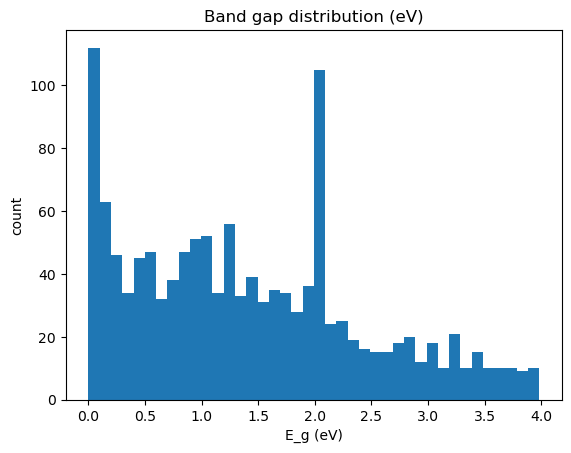

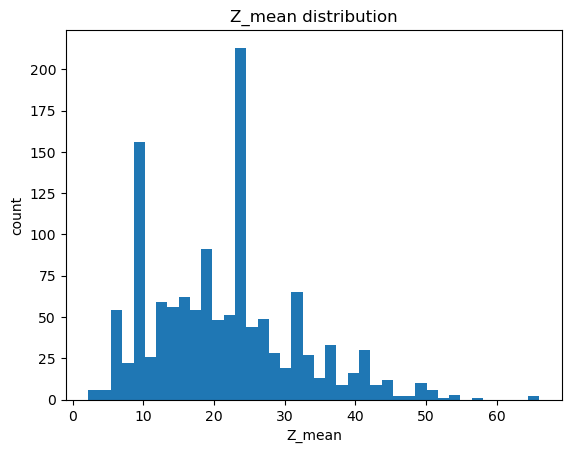

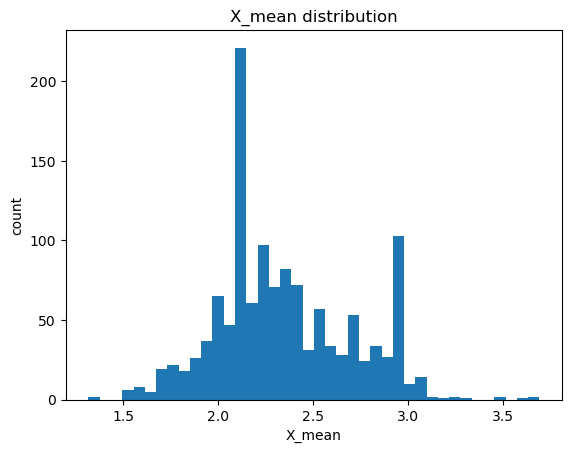

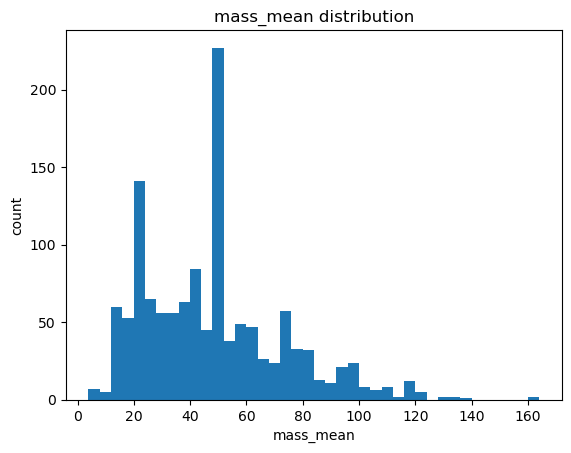

y stats:
count    1285.000000
mean        1.412632
std         1.022250
min         0.000100
10%         0.128100
50%         1.260600
90%         2.942180
max         3.982700

feature stats (first 3 *_mean):
            count       mean        std       min        25%        50%        75%         max
Z_mean     1285.0  21.475683  10.336808  2.250000  13.076923  21.555555  27.000000   66.000000
X_mean     1285.0   2.344669   0.360727  1.315267   2.115000   2.270000   2.590000    3.692000
mass_mean  1285.0  48.053009  25.455019  3.858167  27.451080  48.485867  60.946667  164.095001


In [7]:
# setting paths
FEATS_ALL_PARQ   = "data/comp_X_all.parquet"
FEATS_ALL_CSVGZ  = "data/comp_X_all.csv.gz"
TARGET_ALL_PARQ  = "data/comp_y_all.parquet"
TARGET_ALL_CSVGZ = "data/comp_y_all.csv.gz"
META_CACHE       = "data/comp_cache.csv.gz"   # for nelements counts

# importing libs
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# loading X (parquet preferred, csv.gz fallback)
if os.path.exists(FEATS_ALL_PARQ):
    X = pd.read_parquet(FEATS_ALL_PARQ)
else:
    X = pd.read_csv(FEATS_ALL_CSVGZ)
# loading y
if os.path.exists(TARGET_ALL_PARQ):
    y = pd.read_parquet(TARGET_ALL_PARQ)["band_gap"]
else:
    y = pd.read_csv(TARGET_ALL_CSVGZ)["band_gap"]

# optional: print binaries/ternaries split for sanity
if os.path.exists(META_CACHE):
    meta = pd.read_csv(META_CACHE, usecols=["nelements"])
    n_bin = int((meta["nelements"] == 2).sum())
    n_ter = int((meta["nelements"] == 3).sum())
    total = len(meta)
    print(f"binaries={n_bin} | ternaries={n_ter} | other={total - n_bin - n_ter} | total={total}")

# plotting target histogram
plt.figure()
y.plot.hist(bins=40)
plt.title("Band gap distribution (eV)")
plt.xlabel("E_g (eV)")
plt.ylabel("count")
plt.show()

# plotting a few feature histograms if present
for col in ["Z_mean", "X_mean", "mass_mean"]:
    if col in X.columns:
        plt.figure()
        X[col].plot.hist(bins=40)
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

# printing summary stats
print("y stats:")
print(y.describe(percentiles=[0.1, 0.5, 0.9]).to_string())
keep_cols = [c for c in X.columns if c.endswith("_mean")][:3]
if keep_cols:
    print("\nfeature stats (first 3 *_mean):")
    print(X[keep_cols].describe().T.to_string())


**b: Data for Structure pipeline**  
load raw struct dataset → standardize + attach Structure objects → sanitize + basic geom stats → persist (meta CSV.gz + MSON JSON.gz) → quick QA

*b.1: load + standardize + attach Structure.*

In [8]:
# setting paths
RAW_JSON = "data/semiconductors_full_with_struct.json.gz"   # comes from earlier parsing step
STRUCT_META_CSV = "data/struct_raw_meta.csv.gz"             # will write later (meta only)
STRUCT_MSON_GZ  = "data/struct_mson_sanitized.json.gz"      # will write later (id + structure)

# importing libs
import os, gzip, json
import pandas as pd
from pymatgen.core.structure import Structure

# loading raw records (JSON.gz list of dicts)
if not os.path.exists(RAW_JSON):
    raise FileNotFoundError(f"missing file: {RAW_JSON}")

with gzip.open(RAW_JSON, "rt") as f:
    records = json.load(f)

# standardizing to DataFrame (keep minimal metadata columns up front)
meta_cols = ["material_id","formula_pretty","elements","nelements","band_gap",
             "formation_energy_per_atom","energy_above_hull","is_stable","is_metal","density"]
df = pd.DataFrame([{k: rec.get(k) for k in meta_cols} for rec in records])

# attaching Structure objects (safe parser from MSON dict)
def to_structure_safe(rec):
    s = rec.get("structure", None)
    if s is None:
        return None
    try:
        if isinstance(s, dict):
            return Structure.from_dict(s)
        # if it ever came as JSON string, try to parse then from_dict
        if isinstance(s, str):
            return Structure.from_dict(json.loads(s))
    except Exception:
        return None
    return None

df["struct_obj"] = [to_structure_safe(rec) for rec in records]
df["struct_ok"]  = df["struct_obj"].notna()

# dropping rows without a valid Structure
n_bad = int((~df["struct_ok"]).sum())
if n_bad:
    print(f"dropping {n_bad} rows without valid Structure")
df = df[df["struct_ok"]].reset_index(drop=True)

# quick peek
print(f"✅ loaded and attached Structure objects | rows={len(df)}")
print(df[["material_id","formula_pretty","nelements","band_gap"]].head(3))

✅ loaded and attached Structure objects | rows=1285
  material_id formula_pretty  nelements  band_gap
0  mp-1244872             BN          2    1.5766
1  mp-1244917             BN          2    1.1992
2  mp-1244943             BN          2    1.1885


*b.2: sanitize + basic geometry*

In [9]:
# setting: sanitize structures and compute basic geometry stats
import numpy as np
import pandas as pd
from pymatgen.core.structure import Structure

# asserting prior step is in scope
if "df" not in globals() or "struct_obj" not in df.columns:
    raise RuntimeError("df with 'struct_obj' not found. Run the previous substep to attach Structure objects.")

# setting geometry extractor
def geom_row(s: Structure):
    lat = s.lattice
    a, b, c = float(lat.a), float(lat.b), float(lat.c)
    alpha, beta, gamma = float(lat.alpha), float(lat.beta), float(lat.gamma)
    vol = float(lat.volume)
    nsites = int(len(s))
    dens = float(s.density) if s.density is not None else np.nan
    return dict(a=a, b=b, c=c, alpha=alpha, beta=beta, gamma=gamma, volume=vol, nsites=nsites, density_calc=dens)

# computing geometry for each structure
geo_rows = []
for s in df["struct_obj"]:
    try:
        geo_rows.append(geom_row(s))
    except Exception:
        geo_rows.append(None)

geom = pd.DataFrame(geo_rows)
df = pd.concat([df.reset_index(drop=True), geom], axis=1)

# setting sanity filters
mask = (
    df["nsites"].ge(1) &
    df["volume"].gt(0) &
    df[["a","b","c","alpha","beta","gamma","volume","density_calc"]].applymap(lambda x: np.isfinite(x)).all(axis=1) &
    df["alpha"].between(0.0, 180.0, inclusive="neither") &
    df["beta" ].between(0.0, 180.0, inclusive="neither") &
    df["gamma"].between(0.0, 180.0, inclusive="neither")
)

n_before = len(df)
df = df[mask].reset_index(drop=True)
dropped = n_before - len(df)

# setting final density (prefer existing, fill from calc); keep source as 'density_src'
if "density" in df.columns:
    df["density_src"] = df["density"]
    df["density"] = df["density"].where(np.isfinite(df["density"]), df["density_calc"])
else:
    df["density"] = df["density_calc"]

# quick peek
print(f"✅ sanitized structures | kept={len(df)} | dropped={dropped}")
print(df[["material_id","nelements","nsites","a","b","c","alpha","beta","gamma","volume","density"]].head(3))

✅ sanitized structures | kept=1285 | dropped=0
  material_id  nelements  nsites          a          b          c      alpha  \
0  mp-1244872          2     100  11.327003  10.981774  10.554218  90.070164   
1  mp-1244917          2     100  11.527311  10.993090  10.370069  91.270671   
2  mp-1244943          2     100  10.837137  10.830125  10.365201  88.923377   

        beta      gamma       volume   density  
0  86.115566  87.349094  1308.415165  1.574835  
1  81.606841  93.447575  1297.556556  1.588014  
2  97.341552  90.386445  1206.340619  1.708090  


C:\Users\sayee\AppData\Local\Temp\ipykernel_16324\2453918985.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[["a","b","c","alpha","beta","gamma","volume","density_calc"]].applymap(lambda x: np.isfinite(x)).all(axis=1) &


*b.3: persist outputs*

In [10]:
# setting paths
STRUCT_META_CSV = "data/struct_meta_sanitized.csv.gz"
STRUCT_MSON_GZ  = "data/struct_mson_sanitized.json.gz"

# importing libs
import os, json, gzip, numpy as np, pandas as pd

# asserting df in scope (from previous substep)
if "df" not in globals() or "struct_obj" not in df.columns:
    raise RuntimeError("df with 'struct_obj' not found. Run previous substeps first.")

# setting output dir
os.makedirs("data", exist_ok=True)

# setting meta columns to persist (id + formula + energetics + geom)
keep_meta = [
    "material_id","formula_pretty","elements","nelements","band_gap",
    "formation_energy_per_atom","energy_above_hull","is_stable","is_metal","density",
    "nsites","a","b","c","alpha","beta","gamma","volume"
]
meta_df = df[[c for c in keep_meta if c in df.columns]].copy()

# writing meta CSV.gz
meta_df.to_csv(STRUCT_META_CSV, index=False, compression="gzip")

# setting JSON encoder to handle numpy cleanly
class NumpyJSON(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, (np.integer,)):  return int(o)
        if isinstance(o, (np.floating,)): return float(o)
        if isinstance(o, (np.ndarray,)):  return o.tolist()
        if hasattr(o, "as_dict"):         return o.as_dict()
        return super().default(o)

# building sanitized MSON list: [{"material_id": ..., "structure": {...}}, ...]
mson_records = []    # Markdown Syntax for Object Notation, e.g., Structure.as_dict(). MSON's focus on human readability and its ability to generate JSON and other markup formats, 
                     #whereas JSON is the standard for machine-to-machine communication. 
for mid, s in zip(df["material_id"], df["struct_obj"]):
    if s is None: 
        continue
    mson_records.append({"material_id": mid, "structure": s.as_dict()})

# writing structure JSON.gz
with gzip.open(STRUCT_MSON_GZ, "wt") as f:
    json.dump(mson_records, f, cls=NumpyJSON)

# quick QA
print(f"✅ saved meta CSV → {STRUCT_META_CSV} | rows={len(meta_df)}")
print(f"✅ saved MSON JSON → {STRUCT_MSON_GZ} | records={len(mson_records)}")
print(meta_df.head(3)[["material_id","nelements","nsites","a","b","c","volume"]])

✅ saved meta CSV → data/struct_meta_sanitized.csv.gz | rows=1285
✅ saved MSON JSON → data/struct_mson_sanitized.json.gz | records=1285
  material_id  nelements  nsites          a          b          c       volume
0  mp-1244872          2     100  11.327003  10.981774  10.554218  1308.415165
1  mp-1244917          2     100  11.527311  10.993090  10.370069  1297.556556
2  mp-1244943          2     100  10.837137  10.830125  10.365201  1206.340619


*b.4: adding site statistics using pymatgens structure object*  
- these aren’t used by the paper’s energy GNN; they’re good sanity checks; won’t feed them into the GNN.

In [11]:
# setting paths
STRUCT_META_CSV = "data/struct_meta_sanitized.csv.gz"
STRUCT_MSON_GZ  = "data/struct_mson_sanitized.json.gz"
NEIGHBOR_STATS  = "data/struct_neighbor_stats.csv.gz"

# importing libs
import os, json, gzip, numpy as np, pandas as pd
from pymatgen.core.structure import Structure

# loading df with struct_obj if missing (joining meta + mson)
if "df" not in globals() or "struct_obj" not in df.columns:
    if not (os.path.exists(STRUCT_META_CSV) and os.path.exists(STRUCT_MSON_GZ)):
        raise FileNotFoundError("missing sanitized inputs; run previous structure prep substeps")
    meta = pd.read_csv(STRUCT_META_CSV)
    with gzip.open(STRUCT_MSON_GZ, "rt") as f:
        recs = {r["material_id"]: r["structure"] for r in json.load(f)}
    def to_struct(mid):
        s = recs.get(mid)
        try:
            return Structure.from_dict(s) if isinstance(s, dict) else None
        except Exception:
            return None
    meta["struct_obj"] = meta["material_id"].apply(to_struct)
    df = meta.dropna(subset=["struct_obj"]).reset_index(drop=True)

# setting safe stats helper
def safe_stats(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return dict(mean=np.nan, std=np.nan, vmin=np.nan, vmax=np.nan, vrange=np.nan)
    return dict(
        mean=float(arr.mean()),
        std=float(arr.std(ddof=0)),
        vmin=float(arr.min()),
        vmax=float(arr.max()),
        vrange=float(arr.max() - arr.min()),
    )

# setting distance extractor robust to different neighbor tuple/object shapes
def _extract_dists(neighs, center_site):
    out = []
    for n in neighs:
        # case 1: tuple/list (site, dist, ...)
        if isinstance(n, (tuple, list)):
            if len(n) >= 2 and isinstance(n[1], (int, float)):
                d = float(n[1])
            else:
                try:
                    d = float(center_site.distance(n[0]))
                except Exception:
                    continue
            if d > 1e-6:
                out.append(d)
            continue
        # case 2: object with attr
        for attr in ("nn_distance", "distance"):
            d = getattr(n, attr, None)
            if d is not None:
                d = float(d)
                if d > 1e-6:
                    out.append(d)
                break
        else:
            # case 3: PeriodicSite-like
            try:
                d = float(center_site.distance(n))
                if d > 1e-6:
                    out.append(d)
            except Exception:
                pass
    return out

# setting neighbor summary via adaptive radius (no networkx)
def nn_summary_radius(s: Structure, r_min=3.0, r_max=6.0, step=0.5):
    cn_list, dist_list = [], []
    for i, site in enumerate(s.sites):
        found = False
        r = r_min
        while r <= r_max and not found:
            neighs = s.get_neighbors(site, r)
            dists = _extract_dists(neighs, site)
            if len(dists) > 0:
                cn_list.append(len(dists))
                dist_list.extend(dists)
                found = True
            else:
                r += step
        if not found:
            cn_list.append(np.nan)
    out = {}
    out.update({f"cn_{k}": v for k, v in safe_stats(cn_list).items()})
    out.update({f"bondlen_{k}": v for k, v in safe_stats(dist_list).items()})
    return out

# computing features per structure
rows = []
for _, row in df.iterrows():
    s = row["struct_obj"]
    nn = nn_summary_radius(s)
    feat = {
        "material_id": row["material_id"],
        "nsites": row.get("nsites", len(s)),
        "number_density": float(len(s) / s.lattice.volume),
        "lattice_anisotropy_ab": float(s.lattice.a / s.lattice.b),
        "lattice_anisotropy_bc": float(s.lattice.b / s.lattice.c),
        "lattice_anisotropy_ca": float(s.lattice.c / s.lattice.a),
    }
    feat.update(nn)
    rows.append(feat)

nn_df = pd.DataFrame(rows)

# saving neighbor stats
os.makedirs("data", exist_ok=True)
nn_df.to_csv(NEIGHBOR_STATS, index=False, compression="gzip")

# quick QA
print(f"✅ neighbor stats saved → {NEIGHBOR_STATS} | rows={len(nn_df)} | cols={nn_df.shape[1]}")
print(nn_df.head(3)[[
    "material_id","nsites","number_density",
    "cn_mean","cn_std","bondlen_mean","bondlen_std","bondlen_vmin"
]])

✅ neighbor stats saved → data/struct_neighbor_stats.csv.gz | rows=1285 | cols=16
  material_id  nsites  number_density  cn_mean    cn_std  bondlen_mean  \
0  mp-1244872     100        0.076428     9.16  3.025624      2.277719   
1  mp-1244917     100        0.077068     7.98  2.565073      2.244842   
2  mp-1244943     100        0.082895     9.88  3.063593      2.302047   

   bondlen_std  bondlen_vmin  
0     0.562398      1.112138  
1     0.579908      1.112049  
2     0.556146      1.112209  


*b.5: merge structure features (meta + geometry + neighbor stats) and persist X/y.*  
- handy for non-graph baselines; not used by the paper’s GNN.

In [12]:
# setting paths
STRUCT_META_CSV   = "data/struct_meta_sanitized.csv.gz"     # from earlier substep
NEIGHBOR_STATS    = "data/struct_neighbor_stats.csv.gz"     # from previous substep

STRUCT_X_ALL_PARQ = "data/struct_X_all.parquet"
STRUCT_Y_ALL_PARQ = "data/struct_y_all.parquet"
STRUCT_X_ALL_CSVGZ= "data/struct_X_all.csv.gz"
STRUCT_Y_ALL_CSVGZ= "data/struct_y_all.csv.gz"

# importing libs
import os, pandas as pd, numpy as np

# setting saver with parquet-preferred, csv.gz fallback
def save_frame(df: pd.DataFrame, parquet_path: str, csv_gz_path: str):
    try:
        import pyarrow  # noqa: F401
        df.to_parquet(parquet_path, index=False)
        print(f"✅ saved parquet → {parquet_path}")
    except Exception as e:
        print(f"parquet unavailable ({type(e).__name__}: {e}); saving CSV.gz instead")
        df.to_csv(csv_gz_path, index=False, compression="gzip")
        print(f"✅ saved CSV.gz → {csv_gz_path}")

# loading inputs
meta = pd.read_csv(STRUCT_META_CSV)
nn   = pd.read_csv(NEIGHBOR_STATS)

# merging on material_id
merged = meta.merge(nn, on="material_id", how="inner")

# selecting numeric features; keep target separately
target_col = "band_gap"
meta_keep_for_ref = ["material_id","formula_pretty"]  # kept only for display if needed

num_feats = merged.drop(columns=[c for c in merged.columns if c not in meta_keep_for_ref + [target_col] and merged[c].dtype.kind not in "buifc"])
# above drops non-numeric columns; rebuild numeric table from merged:
X = merged.drop(columns=[c for c in merged.columns if c in (meta_keep_for_ref + [target_col])])
X = X.select_dtypes(include=[np.number])

# imputing NaNs with column medians; replacing infs
X = X.replace([np.inf, -np.inf], np.nan)
meds = X.median(axis=0, numeric_only=True)
X = X.fillna(meds).astype(np.float32)

y = merged[target_col].astype(np.float32)

# saving
save_frame(X, STRUCT_X_ALL_PARQ, STRUCT_X_ALL_CSVGZ)
save_frame(y.to_frame(target_col), STRUCT_Y_ALL_PARQ, STRUCT_Y_ALL_CSVGZ)

# quick QA
print(f"✅ struct features merged | X: {X.shape} | y: {y.shape}")
print(f"   sample cols: {list(X.columns[:8])}")
print(f"   y stats → min={float(y.min()):.3f}, median={float(y.median()):.3f}, max={float(y.max()):.3f}")


✅ saved parquet → data/struct_X_all.parquet
✅ saved parquet → data/struct_y_all.parquet
✅ struct features merged | X: (1285, 27) | y: (1285,)
   sample cols: ['nelements', 'formation_energy_per_atom', 'energy_above_hull', 'density', 'nsites_x', 'a', 'b', 'c']
   y stats → min=0.000, median=1.261, max=3.983


# Graph preparation

a. define graph spec + featurizers  

**Papers' strategy:**   

- nodes: one-hot elements (94-dim) H→Pu
- edges: built by distance cutoff = 4.0 Å
- edge features: Gaussian RBF of distance (no unit vectors / no pos needed)
- target y: formation_energy_per_atom

In [13]:
# setting paths
STRUCT_META_CSV = "data/struct_meta_sanitized.csv.gz"
STRUCT_MSON_GZ  = "data/struct_mson_sanitized.json.gz"
GR_DIR   = "data/graphs_npz_energy"
IDX_PATH = f"{GR_DIR}/index.csv.gz"
MANIFEST = f"{GR_DIR}/manifest.json"

# setting graph config (paper-aligned)
CUTOFF_A = 4.0
N_RBF    = 32
N_ELEM   = 94  # H(1) ... Pu(94)

import os, json, gzip, numpy as np, pandas as pd
from pymatgen.core import Element
from pymatgen.core.structure import Structure

# loading inputs
meta = pd.read_csv(STRUCT_META_CSV)
with gzip.open(STRUCT_MSON_GZ, "rt") as f:
    mson = {r["material_id"]: r["structure"] for r in json.load(f)}

def to_struct(mid):
    s = mson.get(mid)
    return Structure.from_dict(s) if isinstance(s, dict) else None

meta["struct_obj"] = meta["material_id"].apply(to_struct)
meta = meta.dropna(subset=["struct_obj", "formation_energy_per_atom"]).reset_index(drop=True)

# RBF encoder
_centers = np.linspace(0.0, CUTOFF_A, N_RBF, dtype=np.float32)
_sigma   = float(_centers[1] - _centers[0]) if N_RBF > 1 else (CUTOFF_A or 1.0)
_gamma   = 0.5 / (_sigma**2)
def rbf_encode(d):
    d = np.asarray(d, dtype=np.float32).reshape(-1, 1)
    return np.exp(-_gamma * (d - _centers.reshape(1, -1))**2).astype(np.float32)

# one-hot nodes (clip Z to [1, 94])
def one_hot_elem(sym: str):
    try: z = Element(sym).Z
    except Exception: z = 0
    z = max(1, min(N_ELEM, int(z)))
    x = np.zeros(N_ELEM, dtype=np.float32); x[z-1] = 1.0
    return x

def structure_to_graph_energy(s: Structure):
    X = np.vstack([one_hot_elem(site.specie.symbol) for site in s.sites]).astype(np.float32)  # (N, 94)
    i, j, img, d = s.get_neighbor_list(r=CUTOFF_A)                                           # (E,)
    E  = np.vstack([i, j]).astype(np.int64)                                                  # (2, E)
    EA = rbf_encode(d)                                                                        # (E, N_RBF)
    return X, E, EA

def save_npz(path, X, E, EA, y):
    np.savez_compressed(path, x=X, edge_index=E, edge_attr=EA, y=np.array([y], dtype=np.float32))

os.makedirs(GR_DIR, exist_ok=True)

rows = []
ok = fail = 0
for _, r in meta.iterrows():
    mid = str(r["material_id"])
    y   = float(r["formation_energy_per_atom"])
    try:
        X, E, EA = structure_to_graph_energy(r["struct_obj"])
        outp = f"{GR_DIR}/{mid}.npz"
        save_npz(outp, X, E, EA, y)
        rows.append({"material_id": mid, "y": y, "num_nodes": X.shape[0], "num_edges": int(E.shape[1]), "path": outp})
        ok += 1
    except Exception as e:
        rows.append({"material_id": mid, "y": y, "num_nodes": np.nan, "num_edges": np.nan, "path": None, "error": str(e)[:180]})
        fail += 1

pd.DataFrame(rows).to_csv(IDX_PATH, index=False, compression="gzip")
with open(MANIFEST, "w") as f:
    json.dump({"cutoff_A": CUTOFF_A, "n_rbf": N_RBF, "node_encoding": f"one_hot_{N_ELEM}",
               "target": "formation_energy_per_atom", "index_file": os.path.basename(IDX_PATH)}, f)

print(f"✅ energy graphs → {GR_DIR} | ok={ok} fail={fail}")

✅ energy graphs → data/graphs_npz_energy | ok=1285 fail=0


*b. Validate the schema*

In [14]:
# setting paths
GR_DIR       = "data/graphs_npz_energy"
INDEX_CSVGZ  = f"{GR_DIR}/index.csv.gz"
MANIFEST     = f"{GR_DIR}/manifest.json"

# importing libs
import os, json, numpy as np, pandas as pd

# loading manifest + index
with open(MANIFEST, "r") as f:
    man = json.load(f)
idx = pd.read_csv(INDEX_CSVGZ).dropna(subset=["path","y"])
idx = idx[idx["path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)

# setting paper-aligned expectations
NODE_DIM  = 94
N_RBF     = int(man["n_rbf"])
CUTOFF_A  = float(man["cutoff_A"])

# validating first few graphs deterministically
k = min(3, len(idx))
for _, r in idx.head(k).iterrows():
    z = np.load(r["path"])
    x, eidx, eattr, y = z["x"], z["edge_index"], z["edge_attr"], float(z["y"][0])

    # assertions (fail fast if off-spec)
    assert x.ndim == 2 and x.shape[1] == NODE_DIM,  f"node_dim={x.shape[1]} != {NODE_DIM}"
    assert eidx.shape[0] == 2,                      f"edge_index shape {eidx.shape} != (2,E)"
    assert eattr.ndim == 2 and eattr.shape[1] == N_RBF, f"edge_attr_dim={eattr.shape[1]} != N_RBF={N_RBF}"
    print(f"mid={r.material_id} | N={x.shape[0]} | E={eidx.shape[1]} | y(E_f/atom)={y:.4f}")

# summary stats (energy only)
print(f"✅ schema ok | node_dim={NODE_DIM} | edge_attr_dim={N_RBF} | cutoff={CUTOFF_A}")
print(idx["y"].describe(percentiles=[0.1,0.5,0.9]).to_string())


mid=mp-1244872 | N=100 | E=2072 | y(E_f/atom)=-0.7714
mid=mp-1244917 | N=100 | E=2060 | y(E_f/atom)=-0.4968
mid=mp-1244943 | N=100 | E=2212 | y(E_f/atom)=-0.7562
✅ schema ok | node_dim=94 | edge_attr_dim=32 | cutoff=4.0
count    1285.000000
mean       -0.940824
std         0.863043
min        -3.306019
10%        -2.287427
50%        -0.776608
90%        -0.035535
max         2.352094


# Setting step  
why: fair, apples-to-apples comparison across pipelines (paper: same evaluation set for all models)  

goal: produce data/split_ids.json using the graphs index (has material_id + y) and stratify by band gap  

how: load graphs_npz/index.csv.gz → keep rows with valid .npz → bin y for stratification → save train_ids, valid_ids, plus counts

***a: *unify train/valid split by material_id (shared across comp + GNN)***

In [15]:
# setting paths
STRUCT_META_CSV = "data/struct_meta_sanitized.csv.gz"
ENERGY_INDEX    = "data/graphs_npz_energy/index.csv.gz"
SPLIT_JSON      = "data/split_ids_energy.json"

import json, hashlib, pandas as pd
from pymatgen.core import Composition

meta = pd.read_csv(STRUCT_META_CSV, usecols=["material_id","formula_pretty"])
idx  = pd.read_csv(ENERGY_INDEX, usecols=["material_id","y","path"]).dropna(subset=["path","y"])
df   = idx.merge(meta, on="material_id", how="inner")

def reduced_formula(s):
    return Composition(str(s)).reduced_formula

def hash_bucket(formula):
    h = hashlib.md5(formula.encode("utf-8")).hexdigest()
    return int(h, 16) % 100

df["reduced"] = df["formula_pretty"].apply(reduced_formula)
df["bucket"]  = df["reduced"].apply(hash_bucket)

train_ids = df.loc[df["bucket"] <= 84, "material_id"].astype(str).tolist()
valid_ids = df.loc[df["bucket"] >  84, "material_id"].astype(str).tolist()

with open(SPLIT_JSON, "w") as f:
    json.dump({"train_ids": train_ids, "valid_ids": valid_ids,
               "notes": "composition-hash split (MD5 reduced formula, <=84 train)"}, f)

print(f"✅ saved split → {SPLIT_JSON} | train={len(train_ids)} | valid={len(valid_ids)}")

✅ saved split → data/split_ids_energy.json | train=1074 | valid=211


***b: wire the composition pipeline to the shared split (paper: same eval set across modalities)***   

why: apples-to-apples comparison—paper evaluates structure GNN vs baselines on the same IDs  

goal: rebuild comp features → align to saved manifest → impute via manifest medians → split by split_ids.json → save X/y  

how: load comp_cache.csv.gz → re-featurize (same recipe as before) → reorder to comp_feature_manifest.json columns → fill with manifest medians → write comp_X_train_split.*, comp_X_valid_split.*, etc.

In [16]:
# setting paths
COMP_CACHE_CSV   = "data/comp_cache.csv.gz"                # from earlier comp cache step
MANIFEST_JSON    = "data/comp_feature_manifest.json"       # saved feature order + medians
SPLIT_JSON       = "data/split_ids_energy.json"                   # shared IDs from graphs index step

# outputs (parquet preferred, csv.gz fallback)
XTR_PARQ, XTE_PARQ = "data/comp_X_train_split.parquet", "data/comp_X_valid_split.parquet"
YTR_PARQ, YTE_PARQ = "data/comp_y_train_split.parquet", "data/comp_y_valid_split.parquet"
XTR_CSV,  XTE_CSV  = "data/comp_X_train_split.csv.gz",    "data/comp_X_valid_split.csv.gz"
YTR_CSV,  YTE_CSV  = "data/comp_y_train_split.csv.gz",    "data/comp_y_valid_split.csv.gz"

# importing libs
from pymatgen.core import Element

# loading inputs
if not (os.path.exists(COMP_CACHE_CSV) and os.path.exists(MANIFEST_JSON) and os.path.exists(SPLIT_JSON)):
    raise FileNotFoundError("missing one of: comp_cache.csv.gz, comp_feature_manifest.json, split_ids.json")

df = pd.read_csv(COMP_CACHE_CSV)
with open(MANIFEST_JSON, "r") as f:
    manifest = json.load(f)
with open(SPLIT_JSON, "r") as f:
    split = json.load(f)

feature_names = manifest["feature_names"]
medians_dict  = manifest["imputer"]["medians"]

# parsing element→amount JSON and making fractions
def parse_el_amt_json(s):
    try:
        d = json.loads(s)
        d = {str(k): float(v) for k, v in d.items()}
        total = sum(d.values())
        if total <= 0:
            return None
        return {k: v/total for k, v in d.items()}
    except Exception:
        return None

df["el_fracs"] = df["comp_el_amt_json"].apply(parse_el_amt_json)
df = df.dropna(subset=["el_fracs", "band_gap"]).reset_index(drop=True)

# elemental property functions (same as before)
PROP_FUNCS = {
    "Z":               lambda e: e.Z,
    "X":               lambda e: e.X,
    "mass":            lambda e: float(e.atomic_mass) if e.atomic_mass is not None else np.nan,
    "mendeleev_no":    lambda e: e.mendeleev_no,
    "atomic_radius":   lambda e: e.atomic_radius,
}

def prop_vals(fracs: dict, key: str):
    fn = PROP_FUNCS[key]
    vals, wts = [], []
    for sym, w in fracs.items():
        try:
            e = Element(sym)
            v = fn(e)
        except Exception:
            v = np.nan
        vals.append(np.nan if v is None else float(v))
        wts.append(float(w))
    return np.array(vals, dtype=float), np.array(wts, dtype=float)

def wstats(vals, wts):
    mask = np.isfinite(vals)
    if not np.any(mask):
        return dict(mean=np.nan, std=np.nan, vmin=np.nan, vmax=np.nan, vrange=np.nan)
    v, w = vals[mask], wts[mask]
    w = w / w.sum()
    m = float(np.sum(w * v))
    s = float(np.sqrt(np.sum(w * (v - m)**2)))
    return dict(mean=m, std=s, vmin=float(np.min(v)), vmax=float(np.max(v)), vrange=float(np.max(v)-np.min(v)))

def comp_entropy(fracs: dict):
    p = np.array(list(fracs.values()), dtype=float)
    return float(-np.sum(p * np.log(p)))

def comp_max_fraction(fracs: dict):
    return float(max(fracs.values()))

# re-featurize deterministically
rows = []
for _, r in df.iterrows():
    fr = r["el_fracs"]
    feats = {
        "material_id": r["material_id"],
        "H_composition": comp_entropy(fr),
        "max_elem_frac": comp_max_fraction(fr),
        "nelements": r["nelements"],
    }
    for k in PROP_FUNCS.keys():
        v, w = prop_vals(fr, k)
        st = wstats(v, w)
        feats[f"{k}_mean"]  = st["mean"]
        feats[f"{k}_std"]   = st["std"]
        feats[f"{k}_min"]   = st["vmin"]
        feats[f"{k}_max"]   = st["vmax"]
        feats[f"{k}_range"] = st["vrange"]
    feats["band_gap"] = float(r["band_gap"])
    rows.append(feats)

comp_feats = pd.DataFrame(rows)

# align to manifest: ensure columns exist, reorder, impute with manifest medians
X_all = comp_feats.drop(columns=["material_id","band_gap"], errors="ignore")
# ensure every manifest feature exists
for col in feature_names:
    if col not in X_all.columns:
        X_all[col] = np.nan
# drop any extras not in manifest
X_all = X_all[feature_names]
# replace inf -> NaN and impute using manifest medians
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna({k: medians_dict.get(k, 0.0) for k in feature_names})
X_all = X_all.astype(np.float32)
y_all = comp_feats["band_gap"].astype(np.float32)
id_all = comp_feats["material_id"].astype(str)

# filter by split ids
train_ids = set(split["train_ids"])
valid_ids = set(split["valid_ids"])

train_mask = id_all.isin(train_ids)
valid_mask = id_all.isin(valid_ids)

X_tr, y_tr = X_all[train_mask], y_all[train_mask]
X_va, y_va = X_all[valid_mask], y_all[valid_mask]

# saver with parquet-preferred, csv.gz fallback
def save_frame(df: pd.DataFrame, parq: str, csvgz: str):
    try:
        import pyarrow  # noqa: F401
        df.to_parquet(parq, index=False)
        print(f"✅ saved parquet → {parq}")
    except Exception as e:
        print(f"parquet unavailable ({type(e).__name__}: {e}); saving CSV.gz instead")
        df.to_csv(csvgz, index=False, compression="gzip")
        print(f"✅ saved CSV.gz → {csvgz}")

# save
save_frame(X_tr, XTR_PARQ, XTR_CSV)
save_frame(X_va, XTE_PARQ, XTE_CSV)
save_frame(y_tr.to_frame("band_gap"), YTR_PARQ, YTR_CSV)
save_frame(y_va.to_frame("band_gap"), YTE_PARQ, YTE_CSV)

# quick QA
print(f"✅ comp split aligned | X_tr: {X_tr.shape} | X_va: {X_va.shape} | features: {X_all.shape[1]}")
print(f"   y_tr/va min–median–max: "
      f"{float(y_tr.min()):.3f}, {float(y_tr.median()):.3f}, {float(y_tr.max()):.3f}  |  "
      f"{float(y_va.min()):.3f}, {float(y_va.median()):.3f}, {float(y_va.max()):.3f}")

✅ saved parquet → data/comp_X_train_split.parquet
✅ saved parquet → data/comp_X_valid_split.parquet
✅ saved parquet → data/comp_y_train_split.parquet
✅ saved parquet → data/comp_y_valid_split.parquet
✅ comp split aligned | X_tr: (1074, 28) | X_va: (211, 28) | features: 28
   y_tr/va min–median–max: 0.000, 1.275, 3.983  |  0.000, 1.204, 3.918


***c: wire the graph pipeline to the shared split (paper: same eval set across modalities)***   

why: train/validate the GNN on exactly the same materials as the composition baseline  

goal: build a tiny dataset loader that selects train_ids / valid_ids and loads .npz graphs on demand  

how: read graphs_npz/index.csv.gz + split_ids.json → filter rows → loader returns {x, edge_index, edge_attr, (pos), y, material_id}; uses PyTorch tensors if available, else NumPy

In [17]:
# setting paths (paper-aligned energy setup)
GR_DIR       = "data/graphs_npz_energy"
INDEX_CSVGZ  = f"{GR_DIR}/index.csv.gz"
SPLIT_JSON   = "data/split_ids_energy.json"

# importing libs
import os, json, numpy as np, pandas as pd

# setting fail-fast: required files must exist
for p in [INDEX_CSVGZ, SPLIT_JSON]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"missing: {p} — run the energy-graph build cell and the paper split cell")

# loading index and split
idx = pd.read_csv(INDEX_CSVGZ)
with open(SPLIT_JSON, "r") as f:
    split = json.load(f)

# setting strict filter to valid files + targets
idx = idx[idx["path"].notna() & idx["path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].copy()
idx = idx[pd.notna(idx["y"])].copy()
idx["material_id"] = idx["material_id"].astype(str)

# setting split
train_ids = set(split["train_ids"])
valid_ids = set(split["valid_ids"])
train_idx = idx[idx["material_id"].isin(train_ids)].reset_index(drop=True)
valid_idx = idx[idx["material_id"].isin(valid_ids)].reset_index(drop=True)

# setting raw NPZ loader (NumPy only; tensors will be created in the training cell)
def load_npz_graph(path: str):
    z = np.load(path)
    return {
        "x": z["x"],                      # (N, 94)
        "edge_index": z["edge_index"],    # (2, E)
        "edge_attr": z["edge_attr"],      # (E, N_RBF)
        "y": float(z["y"][0])             # scalar formation_energy_per_atom
    }

# setting a tiny dataset wrapper
class GraphDataset:
    def __init__(self, df_index: pd.DataFrame):
        self.df = df_index[["material_id","path","y"]].reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        g = load_npz_graph(r["path"])
        g["material_id"] = r["material_id"]
        return g

# building datasets
train_ds = GraphDataset(train_idx)
valid_ds = GraphDataset(valid_idx)

# quick QA
print(f"✅ graph datasets ready | train={len(train_ds)} | valid={len(valid_ds)}")
s = train_ds[0]
print(f"sample mid={s['material_id']} | x={s['x'].shape} | E={s['edge_index'].shape[1]} | y={s['y']:.4f}")

✅ graph datasets ready | train=1074 | valid=211
sample mid=mp-1244872 | x=(100, 94) | E=2072 | y=-0.7714


***d: preflight checks (no training)***

why: guarantee the graph dataset + split are sane and match the paper-spec before any epochs run  

goal: assert file paths exist, dims match (node=94, edge_attr=RBF), no empty graphs, split coverage is complete; freeze a tiny train-config for reproducibility

In [18]:
# setting paths (paper-aligned energy build)
GR_DIR      = "data/graphs_npz_energy"
INDEX_CSV   = f"{GR_DIR}/index.csv.gz"
MANIFEST    = f"{GR_DIR}/manifest.json"
SPLIT_JSON  = "data/split_ids_energy.json"
TRAIN_CFG   = "data/train_config_energy.json"

import os, json, numpy as np, pandas as pd

# 1) load manifest + index + split (fail-fast)
assert os.path.exists(MANIFEST),   f"missing {MANIFEST}"
assert os.path.exists(INDEX_CSV),  f"missing {INDEX_CSV}"
assert os.path.exists(SPLIT_JSON), f"missing {SPLIT_JSON}"

with open(MANIFEST, "r") as f: man = json.load(f)
idx = pd.read_csv(INDEX_CSV)
with open(SPLIT_JSON, "r") as f: split = json.load(f)

# 2) filter to valid rows/files
idx = idx[idx["path"].notna() & idx["path"].apply(os.path.exists)].copy()
idx = idx[pd.notna(idx["y"])].copy()
idx["material_id"] = idx["material_id"].astype(str)

# 3) split coverage checks (composition-hash split)
train_ids, valid_ids = set(split["train_ids"]), set(split["valid_ids"])
overlap = train_ids & valid_ids
assert not overlap, f"split overlap found: {list(overlap)[:5]}"

have = set(idx["material_id"])
miss_tr = sorted([m for m in train_ids if m not in have])[:5]
miss_va = sorted([m for m in valid_ids if m not in have])[:5]
if miss_tr or miss_va:
    raise RuntimeError(f"split references missing graphs. e.g., train missing: {miss_tr}, valid missing: {miss_va}")

# 4) schema + empties check on a small deterministic slice
NODE_DIM = 94
N_RBF    = int(man["n_rbf"])

probe = idx.sample(n=min(16, len(idx)), random_state=0)
zero_edge_ids = []
for _, r in probe.iterrows():
    z = np.load(r["path"])
    x, eidx, eattr = z["x"], z["edge_index"], z["edge_attr"]
    assert x.ndim == 2 and x.shape[1] == NODE_DIM,  f"node_dim={x.shape[1]} != {NODE_DIM} for {r['material_id']}"
    assert eidx.shape[0] == 2,                      f"edge_index shape bad for {r['material_id']}"
    assert eattr.ndim == 2 and eattr.shape[1] == N_RBF, f"edge_attr_dim={eattr.shape[1]} != {N_RBF} for {r['material_id']}"
    if eidx.shape[1] == 0:
        zero_edge_ids.append(r["material_id"])

if zero_edge_ids:
    raise RuntimeError(f"found graphs with zero edges (cutoff too small). e.g.: {zero_edge_ids[:5]}")

# 5) size summary (counts and simple stats)
train_df = idx[idx["material_id"].isin(train_ids)]
valid_df = idx[idx["material_id"].isin(valid_ids)]
def stats(df):
    # quick E/N stats from a small subsample for speed
    ss = df.sample(n=min(256, len(df)), random_state=0)
    Ns, Es = [], []
    for _, r in ss.iterrows():
        z = np.load(r["path"])
        Ns.append(z["x"].shape[0])
        Es.append(z["edge_index"].shape[1])
    return dict(n=len(df), N_med=int(np.median(Ns)), E_med=int(np.median(Es)))
print("✅ preflight ok")
print("train:", stats(train_df))
print("valid:", stats(valid_df))

# 6) freeze a compact training config (no training yet)
cfg = {
    "node_dim": NODE_DIM,
    "edge_dim": N_RBF,
    "hidden": 256,
    "layers": 6,
    "batch_graphs": 32,
    "lr": 5.55e-4,
    "epochs": 100,
    "target": "formation_energy_per_atom",
    "cutoff_A": float(man["cutoff_A"]),
    "graphs_dir": GR_DIR,
    "index_file": os.path.basename(INDEX_CSV),
    "split_file": os.path.basename(SPLIT_JSON),
}
with open(TRAIN_CFG, "w") as f: json.dump(cfg, f)
print(f"config → {TRAIN_CFG}")


✅ preflight ok
train: {'n': 1074, 'N_med': 20, 'E_med': 307}
valid: {'n': 211, 'N_med': 22, 'E_med': 354}
config → data/train_config_energy.json


# Training
***first-pass energy GNN training***  

why: move from data prep to a minimal, faithful training run on formation energies  

goal: train a SchNet-style message passing model on my energy graphs + composition-hash split  

how: NumPy→Torch loader, deterministic collate, 6-layer MPNN (hidden=256, SiLU), L1 loss (MAE)

In [21]:
# setting paths (paper-aligned energy setup)
GR_DIR      = "data/graphs_npz_energy"
INDEX_CSV   = f"{GR_DIR}/index.csv.gz"
SPLIT_JSON  = "data/split_ids_energy.json"
CKPT_PATH   = "data/gnn_energy_ckpt.pt"

# setting hyperparameters (compact, stable)
HID        = 256
N_LAYERS   = 6
LR         = 5.55e-4
EPOCHS     = 100
BATCH_GRAPHS = 32

# importing libs
import os, json, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F

# loading index + split (deterministic)
idx = pd.read_csv(INDEX_CSV)
with open(SPLIT_JSON, "r") as f: split = json.load(f)
idx = idx[idx["path"].notna() & idx["path"].apply(lambda p: os.path.exists(p))].copy()
idx = idx[pd.notna(idx["y"])].copy()
idx["material_id"] = idx["material_id"].astype(str)

train_ids = set(split["train_ids"]); valid_ids = set(split["valid_ids"])
train_df  = idx[idx["material_id"].isin(train_ids)].reset_index(drop=True)
valid_df  = idx[idx["material_id"].isin(valid_ids)].reset_index(drop=True)

# setting dataset + collate (NumPy -> Torch tensors)
class GraphDataset:
    def __init__(self, df):
        self.df = df[["material_id","path","y"]].reset_index(drop=True)

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        z = np.load(r["path"])
        x     = torch.tensor(z["x"], dtype=torch.float32)           # (N, 94) # NOTE: use torch.tensor(...) instead of torch.from_numpy(...) to avoid build issues
        eidx  = torch.tensor(z["edge_index"], dtype=torch.long)     # (2, E)
        eattr = torch.tensor(z["edge_attr"], dtype=torch.float32)   # (E, RBF)
        y     = torch.tensor([float(z["y"][0])], dtype=torch.float32)
        return {"x": x, "eidx": eidx, "eattr": eattr, "y": y, "mid": r["material_id"]}


def collate(batch):
    # concatenate graphs; adjust edge indices; track graph ids for pooling
    xs, eidxs, eattrs, ys, mids = [], [], [], [], []
    node_offsets, total_nodes = [], 0
    for g in batch:
        N = g["x"].shape[0]
        xs.append(g["x"])
        eidxs.append(g["eidx"] + total_nodes)
        eattrs.append(g["eattr"])
        ys.append(g["y"])
        mids.append(g["mid"])
        node_offsets.append(torch.full((N,), len(node_offsets), dtype=torch.long))
        total_nodes += N
    x = torch.cat(xs, 0)                          # (sumN, 94)
    eidx = torch.cat(eidxs, 1)                    # (2, sumE)
    eattr = torch.cat(eattrs, 0)                  # (sumE, RBF)
    y = torch.cat(ys, 0).unsqueeze(1)                           # (B, 1)
    node_graph = torch.cat(node_offsets, 0)       # (sumN,)
    return x, eidx, eattr, node_graph, y, mids

# setting model (SchNet-style continuous filter conv; no globals)
# Read more about schnet: https://doi.org/10.48550/arXiv.1712.06113

class EnergyGNN(nn.Module):
    def __init__(self, node_dim=94, edge_dim=32, hidden=256, layers=6):
        super().__init__()
        self.in_lin = nn.Linear(node_dim, hidden)                                                       # transforms node features to hidden dimension.
        self.msg_lin = nn.ModuleList([nn.Linear(hidden, hidden, bias=False) for _ in range(layers)])    # linear layer to transform node features before message passing.
        self.edge_mlp = nn.ModuleList([
            nn.Sequential(nn.Linear(edge_dim, hidden), nn.SiLU(), nn.Linear(hidden, hidden))            # builds filters from edge attributes (like distance-based RBFs).
            for _ in range(layers)
        ])
        self.upd = nn.ModuleList([nn.Sequential(nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])  # updates node embeddings after receiving messages.
        self.readout = nn.Sequential(
            nn.SiLU(), nn.Linear(hidden, hidden//2), nn.SiLU(), nn.Linear(hidden//2, 1)                         # combines per-graph embeddings to predict a single energy.
        )

# forward pass
    def forward(self, x, eidx, eattr, node_graph):
        h = self.in_lin(x)                         # (sumN, H), Converts node features to hidden space.
        src, dst = eidx[0], eidx[1]
        
        # message passing loop: Compute messages from neighboring nodes (src) weighted by edge filters (w_ij). Sum (index_add_) messages arriving to each destination node (dst). Update node embeddings with a small MLP + residual connection.
        
        for k in range(len(self.msg_lin)):
            # neighbor projection
            h_msg = self.msg_lin[k](h)            # (sumN, H)
            # edge filters from distances (RBF)
            w_ij = self.edge_mlp[k](eattr)        # (sumE, H)
            # messages: filter ⊙ neighbor states (on src)
            m = w_ij * h_msg[src]                 # (sumE, H)
            # aggregate to destination nodes
            agg = torch.zeros_like(h)
            agg.index_add_(0, dst, m)             # sum over incoming edges
            # residual update
            h = h + self.upd[k](agg)
            
        # mean pool per graph: Averages node embeddings within each graph to get one graph vector. Passes it to the readout MLP → predicts energy (1 number per graph).
        B = int(node_graph.max().item()) + 1
        sum_pool = torch.zeros(B, h.size(1), device=h.device)
        sum_pool.index_add_(0, node_graph, h)
        counts = torch.bincount(node_graph, minlength=B).clamp_min(1).unsqueeze(1)
        g = sum_pool / counts
        return self.readout(g)                    # (B, 1)

# setting loaders (simple manual batching)
train_ds, valid_ds = GraphDataset(train_df), GraphDataset(valid_df)
def data_loader(ds, batch_graphs):
    for i in range(0, len(ds), batch_graphs):
        yield collate([ds[j] for j in range(i, min(i+batch_graphs, len(ds)))])

# setting training (MAE; Adam; linear LR decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyGNN(node_dim=94, edge_dim=int(train_ds[0]["eattr"].shape[1]), hidden=HID, layers=N_LAYERS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
mae = nn.L1Loss()

# Training & Validation epoch runner
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_n = 0.0, 0
    with torch.set_grad_enabled(train):
        for x, eidx, eattr, node_graph, y, _ in loader:
            x, eidx, eattr, node_graph, y = x.to(device), eidx.to(device), eattr.to(device), node_graph.to(device), y.to(device)
            pred = model(x, eidx, eattr, node_graph)
            loss = mae(pred, y)
            if train:
                opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
            total_loss += loss.item() * y.size(0); total_n += y.size(0)
    return total_loss / max(1, total_n)

# Main training loop
best_val, best_state = float("inf"), None
for ep in range(1, EPOCHS+1):
    # linear LR decay
    for pg in opt.param_groups: pg["lr"] = LR * (1 - (ep-1)/EPOCHS)
    tr_loss = run_epoch(data_loader(train_ds, BATCH_GRAPHS), train=True)
    va_loss = run_epoch(data_loader(valid_ds, BATCH_GRAPHS), train=False)
    if va_loss < best_val:
        best_val, best_state = va_loss, {k: v.detach().cpu() for k, v in model.state_dict().items()}
    if ep % 20 == 0 or ep == 1:
        print(f"epoch {ep:03d} | train MAE={tr_loss:.4f} | valid MAE={va_loss:.4f}")

# saving best checkpoint
torch.save({"state_dict": best_state, "config":{"hid":HID,"layers":N_LAYERS}}, CKPT_PATH)
print(f"✅ training done | best valid MAE={best_val:.4f} | ckpt → {CKPT_PATH}")

epoch 001 | train MAE=0.7174 | valid MAE=0.9457
epoch 010 | train MAE=0.3744 | valid MAE=0.5330
epoch 020 | train MAE=0.2867 | valid MAE=0.4182
epoch 030 | train MAE=0.2084 | valid MAE=0.4036
epoch 040 | train MAE=0.1984 | valid MAE=0.3738
epoch 050 | train MAE=0.1744 | valid MAE=0.3390
epoch 060 | train MAE=0.1360 | valid MAE=0.3924
epoch 070 | train MAE=0.1291 | valid MAE=0.3537
epoch 080 | train MAE=0.1123 | valid MAE=0.3855
epoch 090 | train MAE=0.0900 | valid MAE=0.3531
epoch 100 | train MAE=0.0722 | valid MAE=0.3427
✅ training done | best valid MAE=0.3242 | ckpt → data/gnn_energy_ckpt.pt


**Diagnostics:**   
- a. cache valid predictions + errors  

why: build a tidy table for plots/analysis (parity, error vs graph size, error vs composition)  

goal: produce data/diag_valid_predictions.csv.gz with y_true, y_pred, abs_err, N, E, nelements, nsites, formula

In [22]:
# paths
GR_DIR         = "data/graphs_npz_energy"
INDEX_CSV      = f"{GR_DIR}/index.csv.gz"
MANIFEST       = f"{GR_DIR}/manifest.json"
SPLIT_JSON     = "data/split_ids_energy.json"
CKPT_PATH      = "data/gnn_energy_ckpt.pt"
STRUCT_META_CSV= "data/struct_meta_sanitized.csv.gz"
OUT_CSV        = "data/diag_valid_predictions.csv.gz"

# imports
import os, json, numpy as np, pandas as pd, torch
import torch.nn as nn

# load metadata
with open(MANIFEST,"r") as f: man = json.load(f)
idx   = pd.read_csv(INDEX_CSV)
with open(SPLIT_JSON,"r") as f: split = json.load(f)
meta  = pd.read_csv(STRUCT_META_CSV, usecols=["material_id","formula_pretty","nelements","nsites"])

idx = idx[idx["path"].notna() & idx["path"].apply(os.path.exists)].copy()
idx = idx[pd.notna(idx["y"])].copy()
idx["material_id"] = idx["material_id"].astype(str)

valid_ids = set(split["valid_ids"])
valid_df  = idx[idx["material_id"].isin(valid_ids)].merge(meta, on="material_id", how="left").reset_index(drop=True)

# model (same spec as training)
N_RBF = int(man["n_rbf"])
class EnergyGNN(nn.Module):
    def __init__(self, node_dim=94, edge_dim=N_RBF, hidden=256, layers=6):
        super().__init__()
        self.in_lin = nn.Linear(node_dim, hidden)
        self.msg_lin = nn.ModuleList([nn.Linear(hidden, hidden, bias=False) for _ in range(layers)])
        self.edge_mlp = nn.ModuleList([
            nn.Sequential(nn.Linear(edge_dim, hidden), nn.SiLU(), nn.Linear(hidden, hidden))
            for _ in range(layers)
        ])
        self.upd = nn.ModuleList([nn.Sequential(nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])
        self.readout = nn.Sequential(nn.SiLU(), nn.Linear(hidden, hidden//2), nn.SiLU(), nn.Linear(hidden//2, 1))
    def forward(self, x, eidx, eattr, node_graph):
        h = self.in_lin(x); src, dst = eidx[0], eidx[1]
        for k in range(len(self.msg_lin)):
            m = self.edge_mlp[k](eattr) * self.msg_lin[k](h)[src]
            agg = torch.zeros_like(h); agg.index_add_(0, dst, m)
            h = h + self.upd[k](agg)
        B = int(node_graph.max().item()) + 1
        sum_pool = torch.zeros(B, h.size(1)); sum_pool.index_add_(0, node_graph, h)
        counts = torch.bincount(node_graph, minlength=B).clamp_min(1).unsqueeze(1)
        return self.readout(sum_pool / counts)

# load checkpoint
ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg  = ckpt.get("config", {"hid":256,"layers":6})
model = EnergyGNN(hidden=cfg["hid"], layers=cfg["layers"])
model.load_state_dict(ckpt["state_dict"]); model.eval()

# predict over valid set (no TTA)
rows = []
with torch.no_grad():
    for _, r in valid_df.iterrows():
        z = np.load(r["path"])
        x     = torch.tensor(z["x"], dtype=torch.float32)
        eidx  = torch.tensor(z["edge_index"], dtype=torch.long)
        eattr = torch.tensor(z["edge_attr"], dtype=torch.float32)
        node_graph = torch.zeros(x.shape[0], dtype=torch.long)
        y_true = float(z["y"][0])
        y_pred = float(model(x, eidx, eattr, node_graph).squeeze(0))
        rows.append({
            "material_id": r["material_id"],
            "y_true": y_true,
            "y_pred": y_pred,
            "abs_err": abs(y_pred - y_true),
            "N": int(x.shape[0]),
            "E": int(eidx.shape[1]),
            "nelements": int(r.get("nelements", np.nan)) if pd.notna(r.get("nelements", np.nan)) else np.nan,
            "nsites": int(r.get("nsites", np.nan)) if pd.notna(r.get("nsites", np.nan)) else np.nan,
            "formula_pretty": r.get("formula_pretty", None),
        })

diag = pd.DataFrame(rows)
diag.to_csv(OUT_CSV, index=False, compression="gzip")

# quick summary
mae = float((diag["abs_err"]).mean())
rmse = float(np.sqrt(((diag["y_pred"]-diag["y_true"])**2).mean()))
print(f"✅ saved → {OUT_CSV} | n={len(diag)} | MAE={mae:.4f} | RMSE={rmse:.4f}")
print(diag.head(3)[["material_id","formula_pretty","y_true","y_pred","abs_err","N","E","nelements"]])

✅ saved → data/diag_valid_predictions.csv.gz | n=211 | MAE=0.3427 | RMSE=0.5333
  material_id formula_pretty    y_true    y_pred   abs_err   N    E  nelements
0  mp-1008559             BP -0.469228 -0.479607  0.010379   4  104          2
1     mp-1479             BP -0.483304 -0.500460  0.017155   2   56          2
2    mp-28395            B6P -0.326224 -0.074295  0.251928  14  410          2
